# LSTM Bot

## Project Overview

In this project, you will build a chatbot that can converse with you at the command line. The chatbot will use a Sequence to Sequence text generation architecture with an LSTM as it's memory unit. You will also learn to use pretrained word embeddings to improve the performance of the model. At the conclusion of the project, you will be able to show your chatbot to potential employers.

Additionally, you have the option to use pretrained word embeddings in your model. We have loaded Brown Embeddings from Gensim in the starter code below. You can compare the performance of your model with pre-trained embeddings against a model without the embeddings.



---



A sequence to sequence model (Seq2Seq) has two components:
- An Encoder consisting of an embedding layer and LSTM unit.
- A Decoder consisting of an embedding layer, LSTM unit, and linear output unit.

The Seq2Seq model works by accepting an input into the Encoder, passing the hidden state from the Encoder to the Decoder, which the Decoder uses to output a series of token predictions.

## Dependencies

- Pytorch
- Numpy
- Pandas
- NLTK
- Gzip
- Gensim


Please choose a dataset from the Torchtext website. We recommend looking at the Squad dataset first. Here is a link to the website where you can view your options:

- https://pytorch.org/text/stable/datasets.html





__Downloads__

In [2]:
%pip install torchdata
%pip install Cython
%pip install typing-extensions --upgrade
%pip install torch --upgrade
%pip install torchtext==0.9.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.6 MB 4.8 MB/s eta 0:00:01     |██▍                             | 348 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 887.5 MB 5.5 kB/s  eta 0:00:01     |██████████████████████████████▋ | 849.5 MB 51.4 MB/s eta 0:00:01��███████████▊| 878.5 MB 51.4 MB/s eta 0:00:01
     |████████████████████████████████| 21.0 MB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 849 kB 36.3 MB/s eta 0:00:01
     |████████████████████████████████| 317.1 MB 23 kB/s s eta 0:00:01
     |████████████████████████████████| 557.1 MB 5.8 kB/s  eta 0:00:01
ERROR: torchvision 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.13.1 which is incompatible.
ERROR: torchtext 0.12.0 has requirement torch==1.11.0, but you'll have torch 1.13.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-scrip

_Restart the kernel_

In [2]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time
import math
import random
import re

import torchtext
import torch
import torch.optim as optim
import torch.nn as nn
import gensim.downloader

In [3]:
# dataset download
train, test = torchtext.datasets.SQuAD1("root")

The Squad 1 dataset contains 100k+ questions and answers based on over 500 articles. More information can be found [here](https://rajpurkar.github.io/SQuAD-explorer/).

In [4]:
# check number of rows
print(f"Number of training data rows: {train.num_lines}")
print(f"Number of test data rows: {test.num_lines}")

Number of training data rows: 87599
Number of test data rows: 10570


In [5]:
# print out example question
for context, question, answer, answer_start in train:
    print(f"Question: {question}")
    print(f"Answer: {answer[0]}")
    break

Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous


In [6]:
# extract data into dataframe
def convert_to_df(iterator):

    contexts, questions, answers, answer_starts = [], [], [], []

    for line in iterator:
        context, question, answer, answer_start = line


        contexts.append(context)
        questions.append(question)
        answers.append(answer[0])
        answer_starts.append(answer_start[0])

    data_dict = {
        "context": contexts,
        "question": questions,
        "answer": answers,
        "answer_start": answer_starts
    }

    df = pd.DataFrame(data_dict)
    
    return df

df_train = convert_to_df(train)
df_test = convert_to_df(test)

_Data Checks_

In [7]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87598 entries, 0 to 87597
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   context       87598 non-null  object
 1   question      87598 non-null  object
 2   answer        87598 non-null  object
 3   answer_start  87598 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
None


In [8]:
# get a feel for what the data looks like
df_train.sample(10)

,context,question,answer,answer_start
74658,The Qing dynasty (1644–1911) was founded after...,What were the Manchus originally named?,Jurchens,154
37216,"In 1853, Victoria gave birth to her eighth chi...",Who was Victoria's eighth child?,Leopold,50
8912,"It should be emphasized, however, that for Whi...",In what did Whitehead believe that those conce...,primordial nature of God,429
77274,"The Gram stain, developed in 1884 by Hans Chri...",What color is typical for Gram-negative bacter...,pink,272
34576,A third concern with the Kinsey scale is that ...,What is the advantage of measuring these eleme...,the degree of heterosexual and homosexual can ...,878
20044,Although the Spanish Empire had a residual cla...,What title did the Germans give to Kabua?,King of the Ralik Islands,551
21706,The first vertebrates appeared over 500 millio...,How long ago did the first vertebrate organism...,over 500 million years ago,31
73538,"During the turbulent reign of Wang Mang, Han l...",Which Basin did the Han lose authority of?,Tarim,67
57349,Lateral-cut disc records were developed in the...,Where is the museum dedicated to Berliner loca...,Montreal,1250
69412,Any philosophy that assigns crucial importance...,What branch of idealism believes that we can o...,Epistemological,549


__Build a Vocab__

In [9]:
SOS_token = 0
EOS_token = 1

class Vocab:
    """ This vocabulary class cleans and indexes words.
    """
    def __init__(self, name):
        self.name = name
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.word2index = {"<SOS>": 0, "<EOS>": 1}
        self.word2count = {}
        self.count = 2 # count SOS and EOS
    
    # Clean words before adding them to vocab object
    def cleanText(self, text):
        return prepare_text(text)
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    
    # Index words in our vocabulary
    def addWord(self, word):
        if word not in self.word2index: # if word not in index
            self.word2index[word] = self.count # add word and word no to words dictionary
            self.index2word[self.count] = word # add word to index
            self.word2count[word] = 1 # initialise word count
            self.count +=1
            return True
        else:
            self.word2count[word] += 1 # increment word count
            return False

In [10]:
def normalizeString(s):
    s = s.lower().strip() # convert to lower, remove excess spaces
    s = re.sub(r"[^a-zA-Z.!?0-9]+", r" ", s) # remove all non-letter characters
    return s

pairs_train = [[normalizeString(q), normalizeString(a)] 
               for i, (q, a) in df_train[["question", "answer"]].iterrows()]
pairs_test = [[normalizeString(q), normalizeString(a)] 
               for i, (q, a) in df_test[["question", "answer"]].iterrows()]

In [11]:
# print random sentence and answer
random_pair = random.choice(pairs_train)
print(random_pair)

['how are the leads of an axially configured capacitor arranged?', 'on a common axis']


In [12]:
# create and populate vocab object
vocab = Vocab("squad_1")
for question, answer in pairs_train:
    vocab.addSentence(question)
    vocab.addSentence(answer)

In [13]:
# check words added
print(f"Added {vocab.count} words")

Added 66781 words


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def indexesFromSentence(sentence, vocab=vocab):
    # returns a list of indices representing the input sentence
    return [vocab.word2index[word] for word in sentence.split(" ")]

def tensorFromSentence(sentence, vocab=vocab):
    # appends a EOS token and returns a tensor list of indices representing the input sentence
    indexes = indexesFromSentence(sentence)
    indexes.append(EOS_token)
    # view(-1, 1) specifies that we want the shape of 1 column and whatever number of rows to achieve that shape
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    # combines the function above and returns question and answer tensors
    question_tensor = tensorFromSentence(pair[0])
    answer_tensor = tensorFromSentence(pair[1])
    return (question_tensor, answer_tensor)

In [15]:
# test functions
print(random_pair)
tensorsFromPair(random_pair)

['how are the leads of an axially configured capacitor arranged?', 'on a common axis']


(tensor([[   46],
         [   60],
         [    7],
         [12107],
         [    6],
         [  157],
         [49322],
         [33951],
         [49245],
         [26494],
         [    1]], device='cuda:0'),
 tensor([[   33],
         [   12],
         [   64],
         [10382],
         [    1]], device='cuda:0'))

__Download the gensim embedding__

In [16]:
glove_vectors = gensim.downloader.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


_Explore embedding model_

In [17]:
embedding_dim = glove_vectors.vectors.shape[1]
print(embedding_dim)

50


In [18]:
glove_vectors.get_index("man")

300

In [19]:
glove_vectors.most_similar("man")

[('woman', 0.8860337734222412),
 ('boy', 0.8564431071281433),
 ('another', 0.8452839851379395),
 ('old', 0.8372183442115784),
 ('one', 0.827606201171875),
 ('who', 0.8244695663452148),
 ('him', 0.8194693922996521),
 ('turned', 0.8154467940330505),
 ('whose', 0.811974048614502),
 ('himself', 0.807725727558136)]

In [20]:
glove_vectors["man"]

array([-0.094386,  0.43007 , -0.17224 , -0.45529 ,  1.6447  ,  0.40335 ,
       -0.37263 ,  0.25071 , -0.10588 ,  0.10778 , -0.10848 ,  0.15181 ,
       -0.65396 ,  0.55054 ,  0.59591 , -0.46278 ,  0.11847 ,  0.64448 ,
       -0.70948 ,  0.23947 , -0.82905 ,  1.272   ,  0.033021,  0.2935  ,
        0.3911  , -2.8094  , -0.70745 ,  0.4106  ,  0.3894  , -0.2913  ,
        2.6124  , -0.34576 , -0.16832 ,  0.25154 ,  0.31216 ,  0.31639 ,
        0.12539 , -0.012646,  0.22297 , -0.56585 , -0.086264,  0.62549 ,
       -0.0576  ,  0.29375 ,  0.66005 , -0.53115 , -0.48233 , -0.97925 ,
        0.53135 , -0.11725 ], dtype=float32)

_Create weights matrix to map each word embedding to the word in the vocab_

In [21]:
matrix_len = len(vocab.word2index) # length of vocab
weights_matrix = np.zeros((matrix_len, embedding_dim)) # initialise empty weights matrix
words_found = 0

# add words to weights matrix
for i, word in enumerate(vocab.word2index):
    try:
        weights_matrix[i] = glove_vectors[word] # map to glove vector word embedding
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, )) # insert random weights

In [22]:
# check
weights_matrix[vocab.word2index["man"]] - glove_vectors["man"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

__Define Model Structure__

In [23]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, embedding_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        # copy loaded weights matrix into embedding weights - a vector representation of the model word inputs
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        # initialise lstm to take input dimension of embedding size and output hidden dimension
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        
    
    def forward(self, src):
        
        '''
        Inputs: src, the src vector
        Outputs: output, the encoder outputs
                hidden, the hidden state
                cell, the cell state
        '''
        # src shape: (seq_length, batch_size)
        embedding = self.embedding(src).view(1, 1, -1)
        # embedding shape: (seq_length, batch_size, embedding_size)
        output, (hidden, cell) = self.lstm(embedding) # output, hidden and cell state
        
        return hidden, cell
    
    def initHidden(self):# initialise zero tensor with shape (1, 1, hidden_size)
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

class Decoder(nn.Module):
      
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size # length of vocab
        self.num_layers = num_layers        
        
        # self.embedding provides a vector representation of the target to our model
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.embedding.weight.data.copy_(torch.from_numpy(weights_matrix))
        # self.lstm, accepts the embeddings and outputs a hidden state
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        # self.output, predicts on the hidden state via a linear output layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, trg, hidden, cell):
        
        '''
        Inputs: trg, the target vector
        Outputs: predictions, the predictions
                hidden, the hidden state
                cell, the cell state
        '''
        # shape of src is batch_size, but we want (1, batch_size)
        # we want batch_size batches of a single word at a time
        trg = trg.unsqueeze(0) # add one dimension
        embedding = self.embedding(trg).view(1, 1, -1)
        # embedding shape: (1, batch_size, embedding_size)
        output, (hidden, cell) = self.lstm(embedding, (hidden, cell))
        # shape of outputs: (1, batch_size, hidden_size)
        predictions = self.softmax(self.fc(output[0]))
        # shape of predictions: (1, batch_size, length_of_vocab)        
        
        return predictions, hidden, cell
    
    def initHidden(self): # initialise zero tensor with shape (1, 1, hidden_size)
        return torch.zeros(1, 1, self.hidden_size, device=device)
        

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device=device
    
    # teacher forcing ratio - switch between using target and prediction words as inputs for next word
    def forward(self, src, trg, max_trg_len=100, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        
        input_length = src.size(0) # how many question words
        target_length = trg.size(0) if self.training else max_trg_len# how many answer words
        
        target_vocab_size = len(vocab.word2index)
        
        outputs = torch.zeros(target_length, batch_size, target_vocab_size).to(self.device)
        
        for i in range(input_length):
            encoder_hidden, cell = self.encoder(src[i]) # process and encode the entire question
            
        decoder_hidden = encoder_hidden # initialise decoder hidden state with encoder hidden state
        decoder_input = torch.LongTensor([[SOS_token]]).to(device) # add SOS token as first predicted word
        
        for t in range(1, target_length):
            output, decoder_hidden, cell = self.decoder(decoder_input, decoder_hidden, cell)
            
            outputs[t] = output # add decoder predictions array to outputs
            # (batch_size, vocab_size)
            best_guess = output.argmax(1) # get index of best word guess
            teacher_force = False # initialise
            if self.training:
                # use target word if teacher forcing, else use word with the highest predicted value
                teacher_force = random.random() < teacher_forcing_ratio # update where relevant
                decoder_input = trg[t] if teacher_force else best_guess 
            else:
                decoder_input = best_guess
                
            if (teacher_force == False and decoder_input.item() == EOS_token):
                break
            
        return outputs

__Train the model__

In [26]:
# Helper functions

def showPlot(points):
    # This function plots the input points and sets defined tick intervals on the y axis
    plt.figure()
    fig, ax = plt.subplots()
    
    loc = ticker.MultipleLocator(base=0.2) # define tick intervals
    ax.yaxis.set_major_locator(loc) # set y axis tick intervals
    plt.plot(points)
    
def asMinutes(s):
    # format seconds as minutes
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

def timeSince(since, percent):
    # calculate the time between now and since
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))

In [24]:
def calcModel(model, input_tensor, target_tensor, model_optimizer, criterion):
    model_optimizer.zero_grad() # don't accumulate gradient
    
    loss = 0
    epoch_loss = 0
    
    output = model(input_tensor, target_tensor)
    
    num_iter = output.size(0) # number of predicted words
    
    # calculate loss from predicted sentence with expected result
    for ot in range(num_iter):
        loss += criterion(output[ot], target_tensor[ot])
        
    loss.backward() # calculate gradients
    model_optimizer.step() # update weights
    epoch_loss = loss.item() / num_iter # avg loss
    
    return epoch_loss

def trainModel(model, pairs, num_iterations=10000, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    model.train()
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss() # crossentropyloss = softmax + NLLLoss
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0 # reset every plot_every
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(num_iterations)]
    
    for iter_ in range(1, num_iterations+1):
        training_pair = training_pairs[iter_ - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = calcModel(model, input_tensor, target_tensor, optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss        
        
        if iter_ % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print("{0:s} ({1:d} {2:.0f}%), {3:.4f}". format(timeSince(start, iter_ / num_iterations),
                                                 iter_, iter_ / num_iterations * 100, print_loss_avg))
            
        if iter_ % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    showPlot(plot_losses)
            
    torch.save(model.state_dict(), "mytraining.pt")
    return model

In [25]:
# Model hyperparameters
vocab_length = len(vocab.word2index)
input_size_enc = vocab_length
input_size_dec = vocab_length
output_size = vocab_length
enc_embed_size = embedding_dim
dec_embed_size = embedding_dim
hidden_size = 1024
num_layers = 1
teacher_forcing_ratio = 0.5

# Training hyperparameters
learning_rate = 0.01
num_iterations = 1000

# initialise models
encoder = Encoder(input_size_enc, enc_embed_size, hidden_size, num_layers=num_layers)
decoder = Decoder(input_size_dec, dec_embed_size, hidden_size, output_size, num_layers=num_layers)
model = Seq2Seq(encoder, decoder, device).to(device)

0m 19s (- 0m 19s) (500 50%), 3.7291
0m 39s (- 0m 0s) (1000 100%), 2.6068


<Figure size 432x288 with 0 Axes>

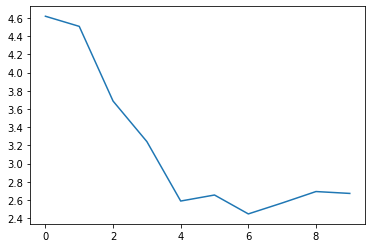

In [27]:
# train model
model_1 = trainModel(model, pairs_train, learning_rate=learning_rate, num_iterations=num_iterations, print_every=500)

In [28]:
def evaluate(model, source, max_trg_len=100):
    model.eval()
    with torch.no_grad():
        input_tensor = tensorFromSentence(source)
        input_length = input_tensor.size()[0]
        
        decoded_words = []
        
        output = model(input_tensor, None)
        
        for ot in range(max_trg_len):
            topv, topi = output[ot].topk(1)
            
            if topi[0].item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(vocab.index2word[topi[0].item()])
    
    return decoded_words

In [36]:
def evaluateRandomly(model, pairs=pairs_test, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(f"source: {pair[0]}")
        print(f"target: {pair[1]}")
        
        output_words = evaluate(model, pair)
        output_sentence = " ".join(output_words)
        print("predicted: {}".format(output_sentence))
        
def evaluateInput(model, input_sentence):
    input_sentence = input_sentence.lower()
    output_words = evaluate(model, input_sentence)
    output_sentence = " ".join(output_words)
    print("predicted: {}".format(output_sentence))

In [37]:
sent = "What is the first day of the week?"
evaluateInput(model_1, sent)

predicted: <SOS> <EOS>


In [72]:
tensorFromSentence(sent)

tensor([[  38],
        [  39],
        [   7],
        [1786],
        [4036],
        [   1]], device='cuda:0')

In [48]:
test = tensorsFromPair(random.choice(pairs_train))
test

(tensor([[  379],
         [ 1382],
         [   21],
         [  785],
         [    7],
         [ 3882],
         [30209],
         [12375],
         [   92],
         [14637],
         [    4],
         [35020],
         [    1]], device='cuda:0'),
 tensor([[48967],
         [49067],
         [    1]], device='cuda:0'))

In [96]:
a = model_1(test[0], test[1])

In [98]:
a[2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [21]:
#torch.zeros(target_length, batch_size, target_vocab_size)
b = torch.zeros(10, 1, 10)
b.shape

torch.Size([10, 1, 10])

In [24]:
b[1:].view(-1, b.shape[-1]).shape

torch.Size([9, 10])

In [66]:
torch.LongTensor([[SOS_token]]).to(device)

tensor([[0]], device='cuda:0')